<a href="https://colab.research.google.com/github/carlos-cardoso84/book_blue_prints_aprendizado_maquina/blob/master/ESTUDO_DE_CASO_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#https://github.com/tatsath/fin-ml/blob/master/Chapter%205%20-%20Sup.%20Learning%20-%20Regression%20and%20Time%20Series%20models/Case%20Study%201%20-%20Stock%20Price%20Prediction/StockPricePrediction.ipynb

## OBJETIVO:
USAR MODELOS DE APRENDIZADO SUPERVISIONADO PARA PREVER O PREÇO DAS AÇÕES DA MICROSOFT USANDO ATIVOS CORRELACIONADOS E SEU PRÓPRIO HISTÓRICO

## DADOS E PACOTES

In [2]:
#para os modelos
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
#para analises e avaliação dos modelos
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, chi2, f_regression
#modulos para as redes neurais
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import SGD
from scikeras.wrappers import KerasRegressor
#modulos para time series
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
#preparação e visualização dos dados
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
import pandas_datareader.data as web

In [3]:
#DADOS
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

In [4]:
# Baixar ações do Yahoo com yfinance
stk_data = yf.download(stk_tickers, start="2010-01-01", group_by='ticker')

[*********************100%***********************]  3 of 3 completed


In [5]:
# Baixar câmbio e índices do FRED (continua igual)
ccy_data = web.DataReader(ccy_tickers, 'fred', start='2010-01-01')
idx_data = web.DataReader(idx_tickers, 'fred', start='2010-01-01')

In [6]:
#definindo a variável independente (Y)
return_period = 5
Y = np.log(stk_data.loc[:,'MSFT'][['Close']]).diff(return_period).\
    shift(-return_period)
Y.columns = ["MSFT_pred"]

In [7]:
#montando a base
stk_data = stk_data.sort_index()
ccy_data = ccy_data.sort_index()
idx_data = idx_data.sort_index()
X1 = np.log(stk_data.loc[:,'GOOGL'][['Close']]).diff(return_period)
X2 = np.log(stk_data.loc[:,'IBM'][['Close']]).diff(return_period)
X1.columns  = ['GOOGL']
X2.columns  = ['IBM']
X1 = pd.concat([X1,X2], axis=1)
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)
X4 =pd.concat([np.log(stk_data.loc[:,'MSFT'][['Close']]).diff(i)\
              for i in [return_period, return_period*3,\
               return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT','MSFT_3DT','MSFT_6DT','MSFT_12DT']
X = pd.concat([X1,X2,X3,X4], axis=1)
dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, 'MSFT_pred']
X = dataset.loc[:, X.columns]

## ANÁLISE EXPLORATÓRIA

In [8]:
dataset.sort_index().head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2015-06-29,-0.001579,-0.033484,-0.028789,-0.006347,-0.003736,-0.031200,-0.029313,0.391766,-0.041065,-0.030191,-0.078390,0.102938
2015-07-07,0.029362,0.016092,0.012380,0.000491,-0.018223,0.008797,0.008894,-0.124871,-0.001579,-0.026288,-0.057033,0.066482
2015-07-15,-0.004819,0.075120,0.032383,0.027412,0.017305,0.029236,0.030073,-0.396099,0.033781,-0.003273,-0.025033,0.070783
2015-07-22,0.016335,0.174223,-0.049755,0.001532,-0.000256,0.003198,-0.011093,-0.087630,-0.004819,0.030998,-0.002413,-0.046757
2015-07-29,0.027487,-0.049652,0.004604,-0.001775,0.000448,-0.002643,-0.005598,0.030872,0.016335,0.045296,0.009987,-0.034785


In [9]:
#descritiva
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000
mean,0.004809,0.003416,0.002659,0.000393,-0.000428,0.002081,0.001696,0.000682,0.004817,0.014888,0.028418,0.057502
std,0.032848,0.037880,0.034874,0.013359,0.013653,0.024335,0.024364,0.159530,0.031924,0.055428,0.071688,0.092587
min,-0.137317,-0.131259,-0.173146,-0.052258,-0.098355,-0.140676,-0.166713,-0.542439,-0.137317,-0.239569,-0.299103,-0.245550
25%,-0.013618,-0.019020,-0.014533,-0.006705,-0.007603,-0.007789,-0.008831,-0.097966,-0.012999,-0.014516,-0.011700,0.000716
50%,0.005656,0.006697,0.003084,0.001051,-0.000611,0.003471,0.003032,-0.016317,0.006853,0.017477,0.031452,0.067946
75%,0.024885,0.025169,0.022848,0.007599,0.007694,0.014955,0.014826,0.079093,0.023610,0.045189,0.074223,0.120182
max,0.164103,0.174223,0.175315,0.052731,0.075400,0.160395,0.183091,0.738522,0.164103,0.244822,0.248933,0.293344


## VISUALIZAÇÃO DOS DADOS

<Axes: title={'center': 'Matriz de Correlação'}>

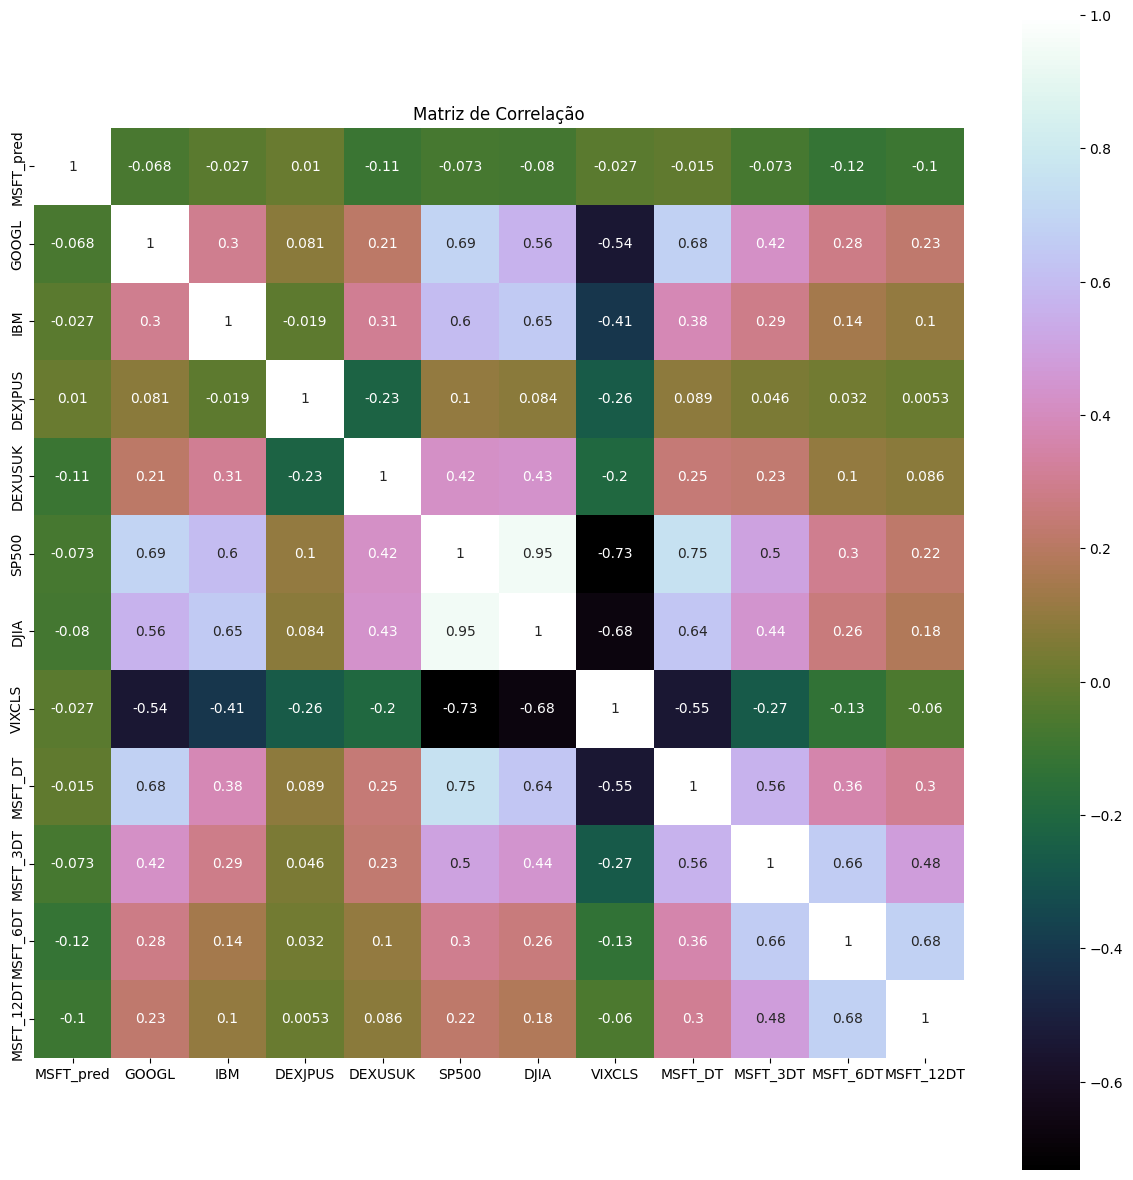

In [10]:
#CORRELAÇÃO
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title("Matriz de Correlação")
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

<Figure size 1500x1500 with 0 Axes>

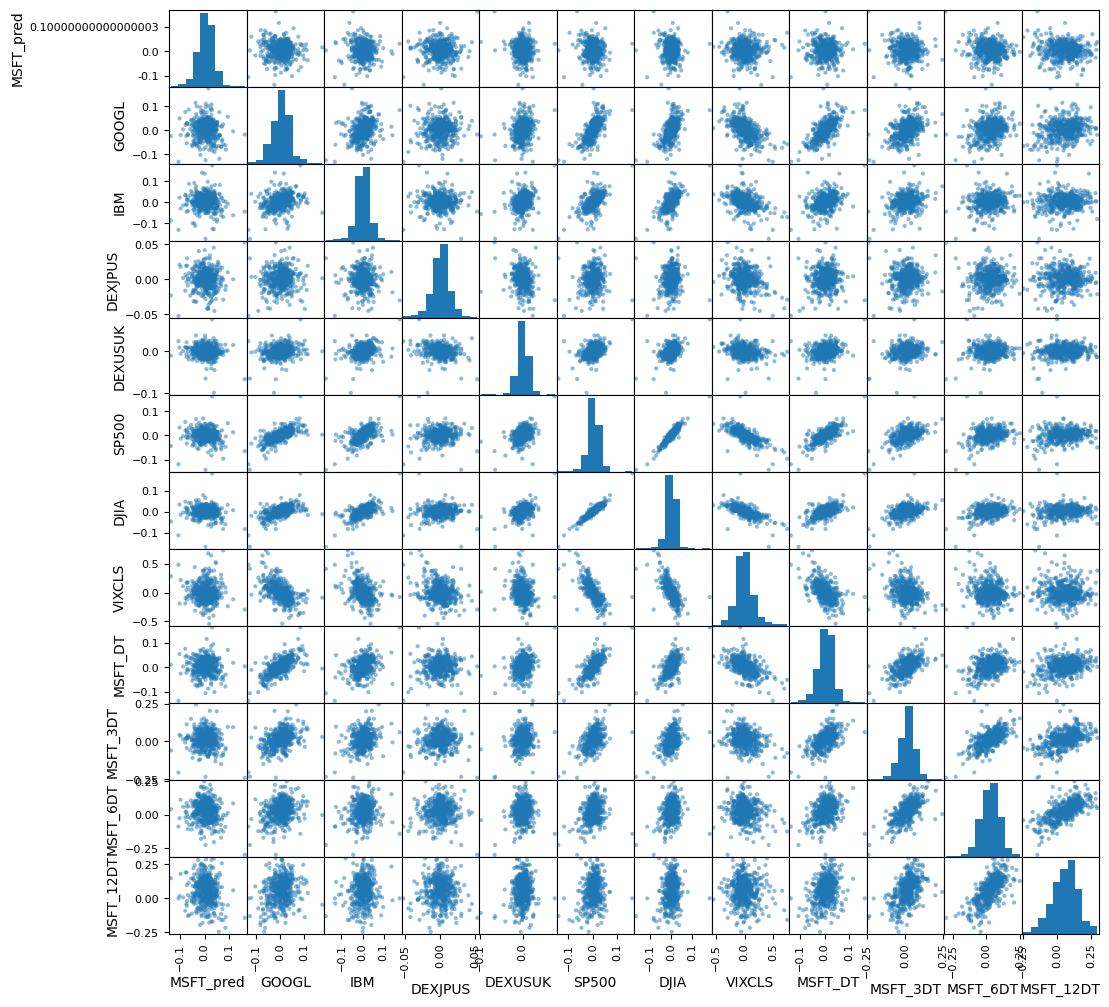

In [11]:
plt.figure(figsize=(15,15))
scatter_matrix(dataset, figsize = (12,12))
plt.show()


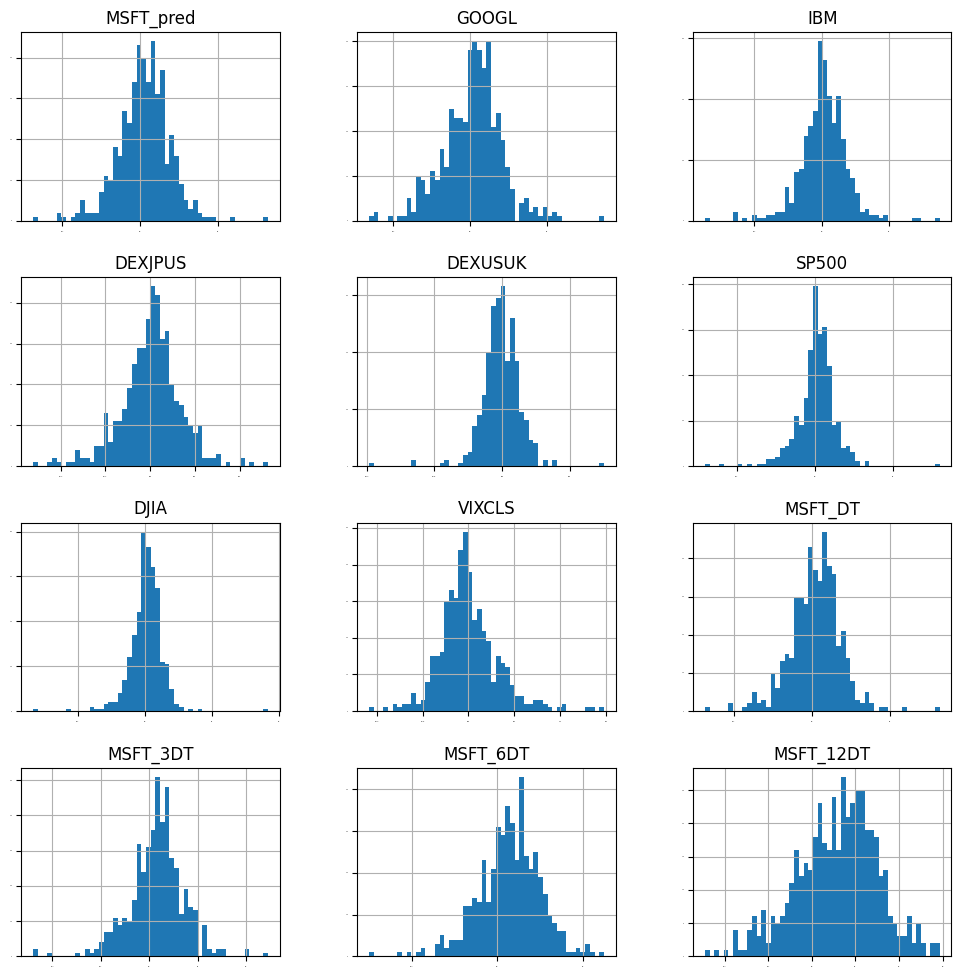

In [12]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

## ANÁLISE DA SÉRIE TEMPORAL

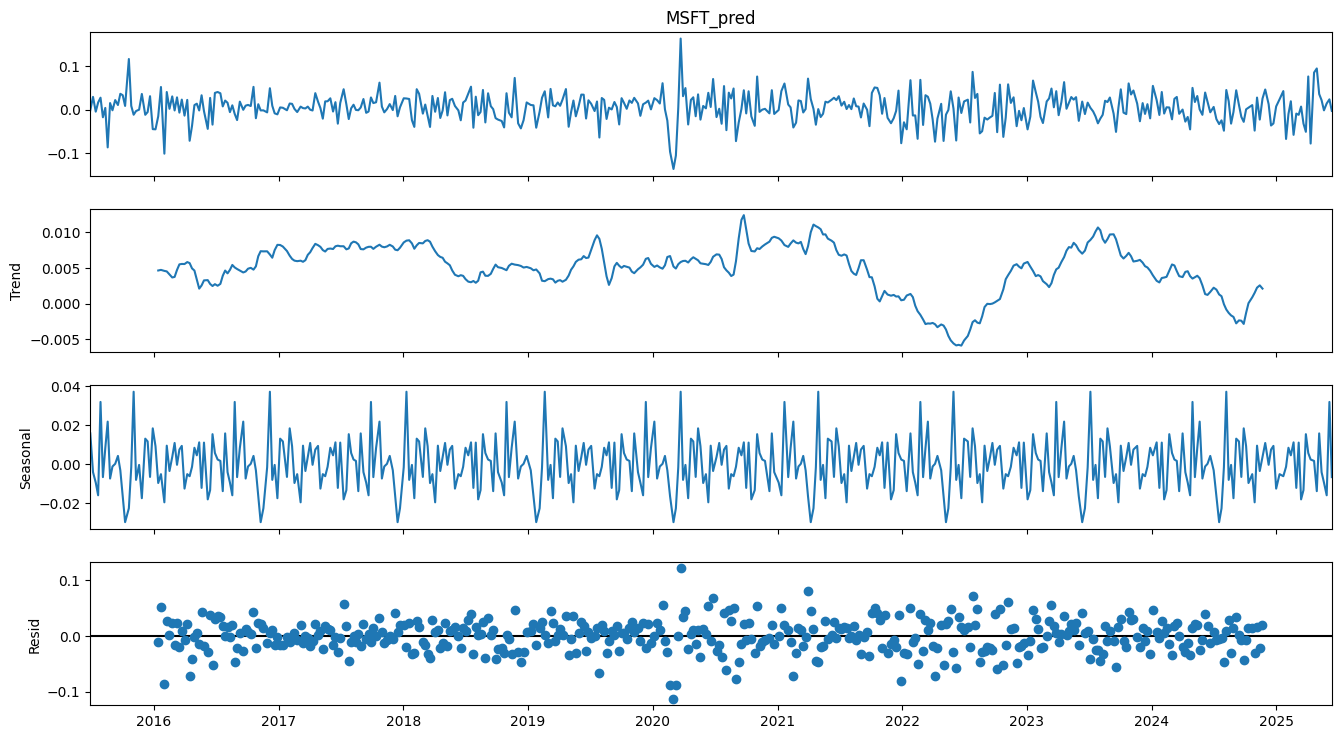

In [13]:
res = sm.tsa.seasonal_decompose(Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

## PREPARAÇÃO DOS DADOS

In [14]:
# TREINO E TESTE
validation_size = 0.2
train_size = int(len(X) * (1 - validation_size)) # Corrected calculation
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)] # Changed X to Y here

## MÉTRICAS DE AVALIAÇÃO

In [15]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error.
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error'

## COMPARANDO MODELOS E ALGORTIMOS

### REGRESSÃO E ÁRVORES

In [16]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

### REDES NEURAIS

In [17]:
models.append(('MLP', MLPRegressor()))

### MÉTODOS ENSEMBLE

In [18]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

EXECUTANDO OS MODELOS - VALIDAÇÃO CRUZADA

In [19]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)

    ## K Fold analysis:

    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)

    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)

    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001124 (0.000289) 0.001035 0.001042
LASSO: 0.001087 (0.000243) 0.001083 0.001051
EN: 0.001087 (0.000243) 0.001083 0.001051
KNN: 0.001356 (0.000251) 0.000851 0.001231
CART: 0.002179 (0.000410) 0.000000 0.001798
SVR: 0.001179 (0.000318) 0.001052 0.001075
MLP: 0.001216 (0.000411) 0.001235 0.001230
ABR: 0.001129 (0.000257) 0.000733 0.001011
GBR: 0.001359 (0.000274) 0.000258 0.001129
RFR: 0.001197 (0.000236) 0.000160 0.001079
ETR: 0.001210 (0.000197) 0.000000 0.001091


### COMPARANDO OS RESULTADOS


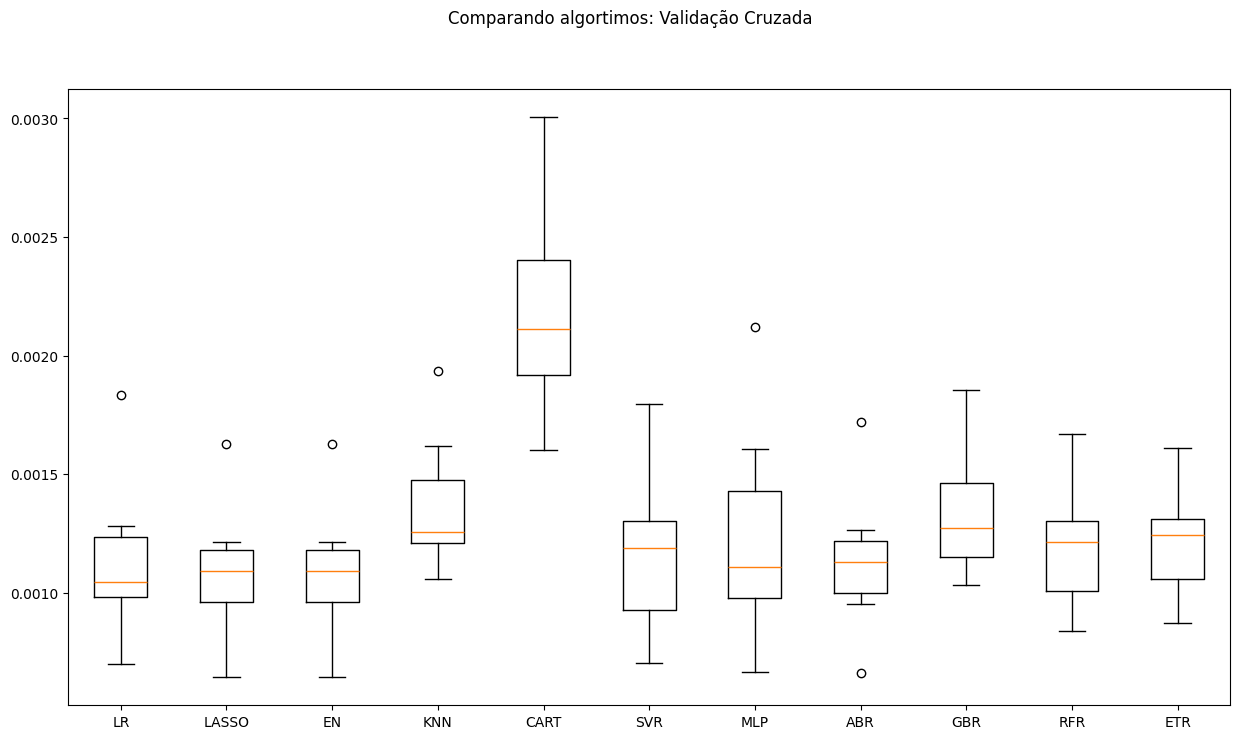

In [20]:
fig = plt.figure()
fig.suptitle('Comparando algortimos: Validação Cruzada')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

### COMPARANDO TREINO E TESTE

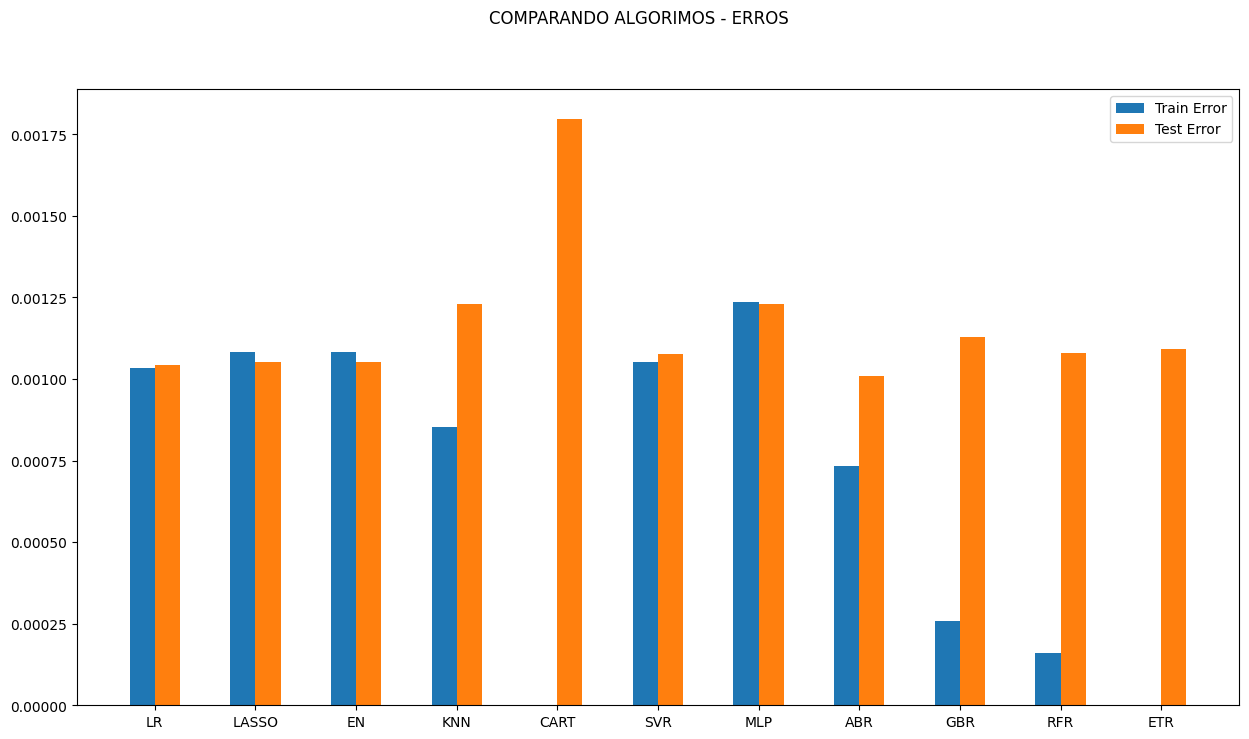

In [21]:
# compare algorithms
fig = plt.figure()

ind = np.arange(len(names))
width = 0.25

fig.suptitle('COMPARANDO ALGORIMOS - ERROS')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()

INTERESSANTE VER OS CASOS DE OVERFITTING, ONDE NO TREINO O ERRO É PRATICAMENTE ZERO E NO TESTE ELE APARECE BEM ACIMA (EXTRATREESREGRESSOR, POR EXEMPLO)

## MODELOS BASEADOS EM SÉRIES TEMPORAIS

In [22]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [23]:
model_arima=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = model_arima.fit()

In [24]:
error_Training_arima = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.0010088140197565018

### LSTM

In [25]:
seq_len = 2 #Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [26]:
# Lstm Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed
    model.add(Dense(1))
    # Use 'learning_rate' instead of 'lr' for SGD optimizer
    # Explicitly cast momentum to float
    optimizer = SGD(learning_rate=learn_rate, momentum=float(momentum))
    model.compile(loss='mse', optimizer='adam') # Note: The optimizer defined above is not used here.
    return model

# Keep the rest of the code as is
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

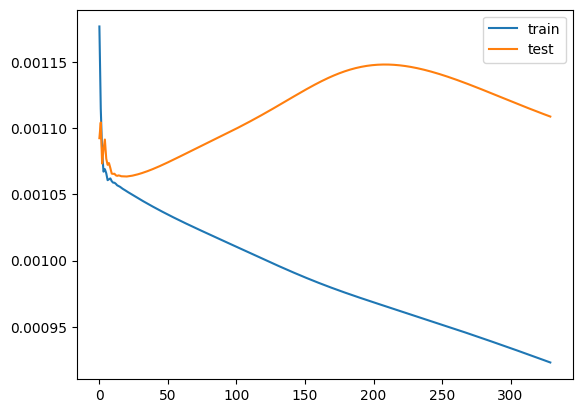

In [27]:
#Visual plot to check if the error is reducing
plt.plot(LSTMModel_fit.history['loss'], label='train')
plt.plot(LSTMModel_fit.history['val_loss'], label='test')
plt.legend()
plt.show()

In [28]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Append dos resultados

In [29]:
# Append dos resultados
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_arima)
train_results.append(error_Training_LSTM)

# Append ARIMA and LSTM names *before* plotting
names.append("ARIMA")
names.append("LSTM")

COMPARANDO TODOS OS ALGORITMOS

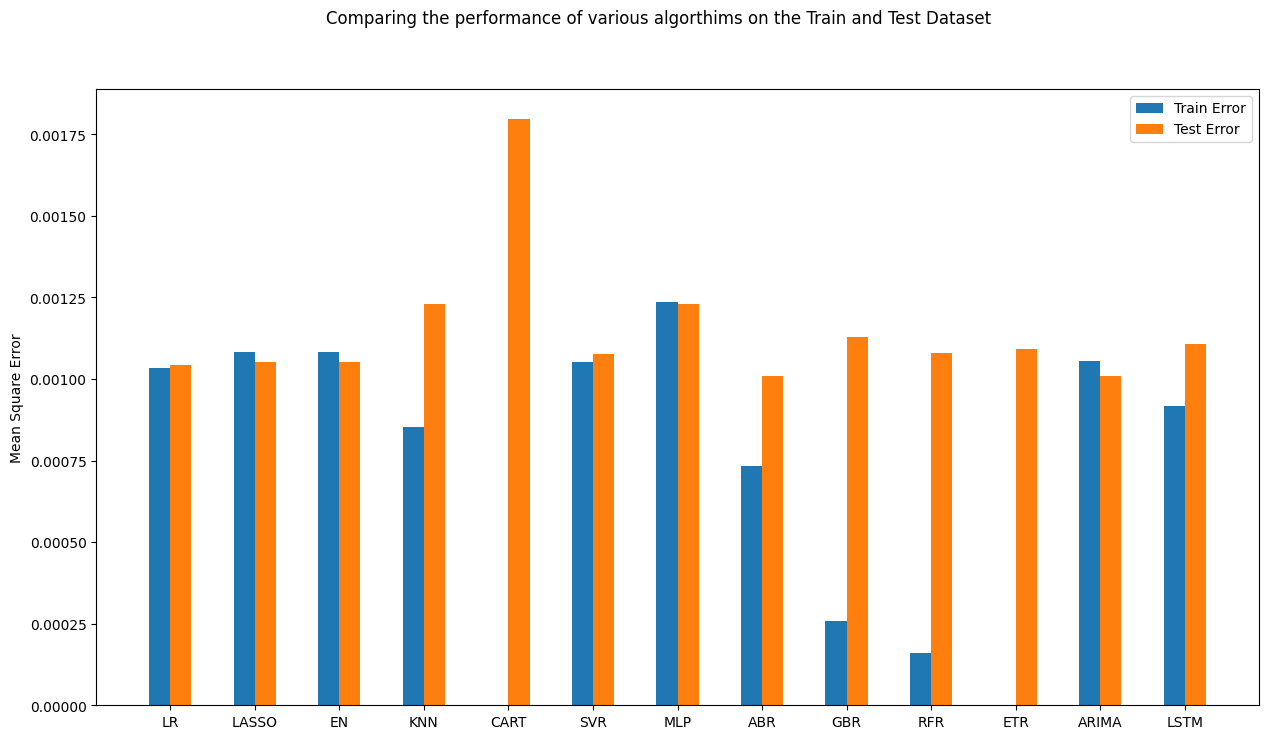

In [30]:
# compare algorithms
fig = plt.figure()

# Create new lists specifically for the final comparison plot
final_names = []
final_train_results = []
final_test_results = []

# Populate the new lists with results from the initial models
# Assuming 'names', 'train_results', 'test_results' from the loop above hold these results
for i in range(len(models)): # Iterate through the original models
    final_names.append(names[i])
    final_train_results.append(train_results[i])
    final_test_results.append(test_results[i])

# Append the ARIMA and LSTM results specifically
final_names.append("ARIMA")
final_test_results.append(error_Test_ARIMA)
final_train_results.append(error_Training_arima)

final_names.append("LSTM")
final_test_results.append(error_Test_LSTM)
final_train_results.append(error_Training_LSTM)


# Recalculate ind using the updated final_names list
ind = np.arange(len(final_names))
width = 0.25

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
# Use the new lists for plotting
plt.bar(ind - width/2, final_train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, final_test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(final_names)
plt.ylabel('Mean Square Error')
plt.show()

## TUNE - ARIMA

In [31]:
#Grid Search for ARIMA Model
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.0010617
ARIMA(0, 0, 1) MSE=0.0010552
ARIMA(0, 1, 0) MSE=0.0016753
ARIMA(0, 1, 1) MSE=0.0010822
ARIMA(1, 0, 0) MSE=0.0010543
ARIMA(1, 0, 1) MSE=0.0010617
ARIMA(1, 1, 0) MSE=0.0014987
ARIMA(1, 1, 1) MSE=0.0010964
ARIMA(2, 0, 0) MSE=0.0010542
ARIMA(2, 0, 1) MSE=0.0010539
ARIMA(2, 1, 0) MSE=0.0014388
ARIMA(2, 1, 1) MSE=0.0010902
Best ARIMA(2, 0, 1) MSE=0.0010539


## MODELO FINAL

In [32]:
# prepare model
modelarima_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = modelarima_tuned.fit()

In [33]:
# estimate accuracy on validation set
predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.0010088140197565018


## SALVANDO O PICKLE DO MODELO

In [34]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model.sav'
dump(model_fit_tuned, open(filename, 'wb'))